### Modelling

If you want to see what the LLM was actually outputting. Please see the "raw" notebooks in the other folder. This Notebook cleans up some of the outputs from the LLM. I give some commentary on the cleaning that was done.

I think one should be refining/curating the results they get from LLMs rather than comepletely relying on it. Sometimes the output isnt suitable and is missing a few things. Also, Since we work with data that the LLM cannot see, intervention is necessar

Let's not give the LLM something too trivial like a basic scikit learn model. Let's try something a little more advanced.y.

In [1]:
#IMPORTS
import optuna
import plotly
import pickle
import shap
import pandas as pd

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score #I added this last one
from sklearn.metrics import accuracy_score, classification_report
import optuna.visualization as vis

In [2]:
df = pd.read_csv('../data/Telco_ML_ready.csv')

We'll keep the wording of this prompt simple for now. I'll make minimal interventions so that the code can work with our data.

**Prompt:** Optimise an XGBoost classifier using Optuna

**Result:**

In [3]:
#split data (passed in our data)
X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis=1), df['Churn'], test_size=0.3, random_state=1)

In [4]:
def objective(trial):
   xgb_model = XGBClassifier(
       n_estimators=trial.suggest_int("n_estimators", 100, 1200),
       max_depth=trial.suggest_int("max_depth", 1, 10),
       min_child_weight=trial.suggest_float("min_child_weight", 0, 20),
       learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
       gamma=trial.suggest_float("gamma", 1e-5, 1, log=True),
       subsample=trial.suggest_float("subsample", 0.05, 1.0),
       colsample_bytree=trial.suggest_float("colsample_bytree", 0.05, 1.0),
       reg_alpha=trial.suggest_float("reg_alpha", 1e-5, 1e-1, log=True),
       reg_lambda=trial.suggest_float("reg_lambda", 1e-5, 1e-1, log=True),
       random_state=99
   )

   score = cross_val_score(xgb_model, X_train, y_train, cv=3)
   accuracy = score.mean()
    
   return accuracy

The LLM used depreciated optuna methods. Ive changed them to current methods.

I also added cross validation (I should have specified that in my prompt!).

Added min_child_weight, Changed search areas to my preference. Added random state.

In [13]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=11) #I added n_jobs to speed things up

  0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')

trial = study.best_trial
print(f' Value: {round(trial.value, 3)}')
print(' Params: ')

for key, value in trial.params.items():
   print(f'   {key}: {round(value, 3)}')

Number of finished trials: 100
Best trial:
 Value: 0.802
 Params: 
   n_estimators: 356
   max_depth: 2
   min_child_weight: 10.362
   learning_rate: 0.031
   gamma: 0.015
   subsample: 0.733
   colsample_bytree: 0.749
   reg_alpha: 0.01
   reg_lambda: 0.067


Changed to f-strings rather than using the old format method. Rounded to 3 dp.

I want to see some graphical output regarding the optimisation process. Can the LLM handle that?

**Prompt:** I have an optuna study. Can you use its vizualization features to provide a few plots that show the things about the optimization process and the hyperparameters?

**Result:**

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.


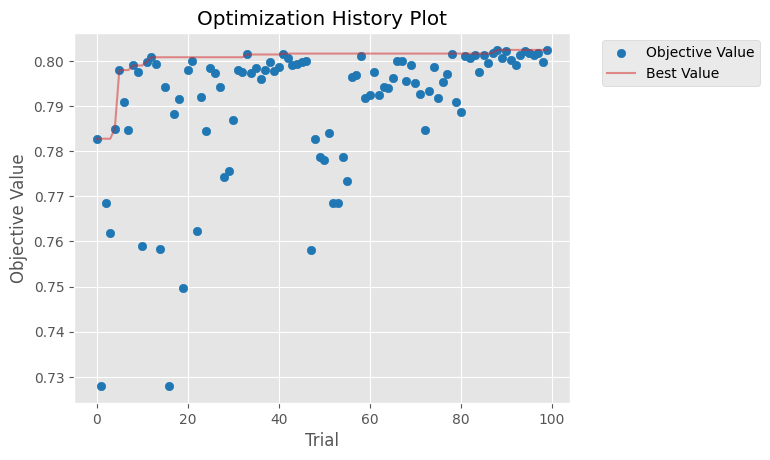

In [15]:
optimization_history_plot = vis.matplotlib.plot_optimization_history(study)

This initially didnt work because i forgot to specify that it must use the matplot lib variant. The default is **Plotly**, after installing that library there was no issue.

**Note:** I have changed the plotting library to matplotlib so that we can see the charts rendered in github. The "raw" notebook has the plotly charts.

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.


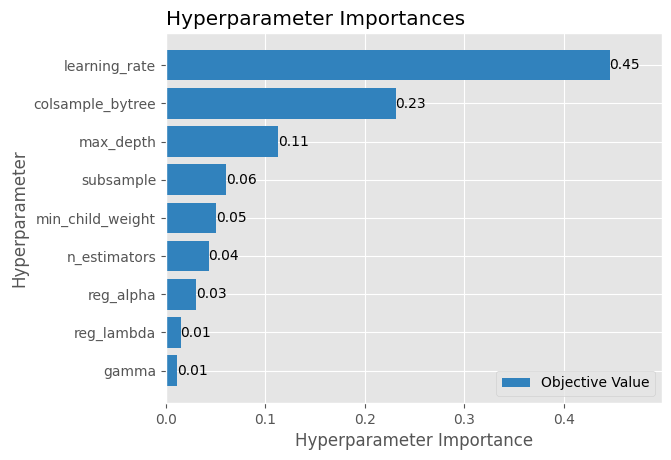

In [16]:
param_importance_plot = vis.matplotlib.plot_param_importances(study)

plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
[W 2023-11-20 20:46:05,714] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


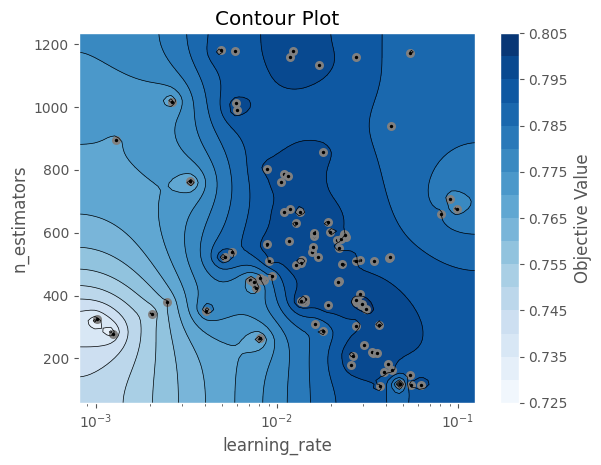

In [17]:
contour_plot = vis.matplotlib.plot_contour(study, params=["n_estimators", "learning_rate"]) #added in our xgb hyperparams

plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
plot_slice is experimental (supported from v2.2.0). The interface can change in the future.


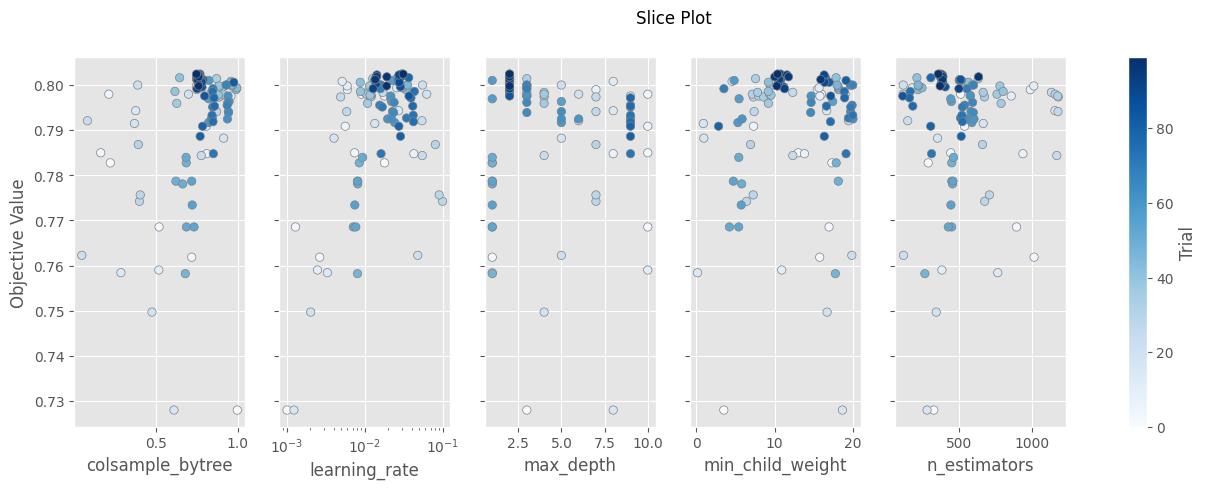

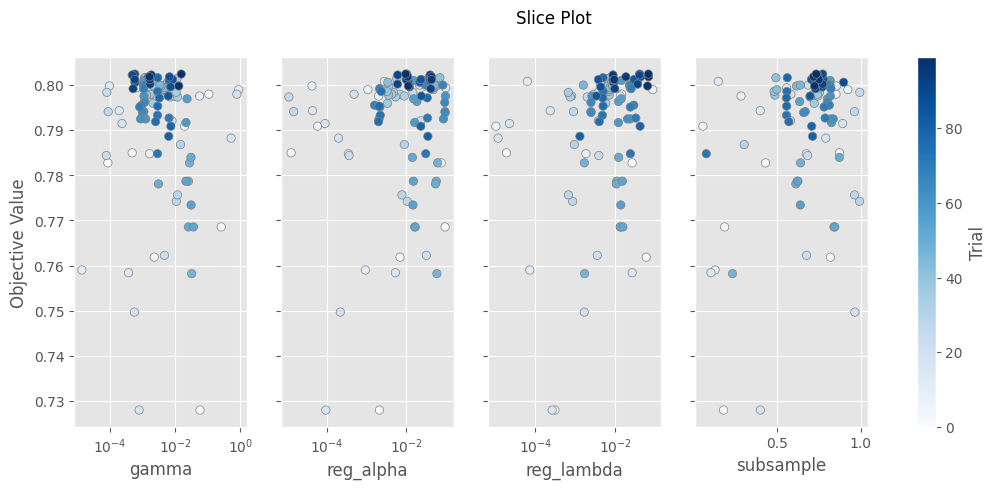

In [18]:
slice_plot = vis.matplotlib.plot_slice(study, ["learning_rate", "n_estimators", "colsample_bytree", "min_child_weight", "max_depth"]) #added in our xgb hyperparams

slice_plot = vis.matplotlib.plot_slice(study, ["gamma", "reg_alpha", "reg_lambda", "subsample"]) #added in our xgb hyperparams

Easy peasy, just had to add in the names of our own hyperparams. I suppose this result isnt too impressive, it was just rolling through the differnt visualisations that optuna has. Thats still useful for someone who is unfamiliar with the library though.

Now how about retraining the best model?

**Prompt:** I have an optuna study. Please retrain my xgboost classifier model using the best parameters from that optuna study. Then save the model object as a pickle file.

**Result:**

In [19]:
best_params = study.best_params

best_xgb_model = XGBClassifier(
  n_estimators=best_params['n_estimators'],
  max_depth=best_params['max_depth'],
  learning_rate=best_params['learning_rate'],
  gamma=best_params['gamma'],
  subsample=best_params['subsample'],
  colsample_bytree=best_params['colsample_bytree'],
  reg_alpha=best_params['reg_alpha'],
  reg_lambda=best_params['reg_lambda']
)

best_xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7488908113372764, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.015405277200890952,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.031124432435208505,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=356, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(best_xgb_model, file)

The LLM actually asked for clarification first. It wanted me to send it the optimisation code before answering my prompt. For some reason the code was indented by one space, oh well. 

Otherwise, another win for codeLlama!

Lets get some inference from our model using Shapely. I'll be a bit vague to see what the LLM comes up with.

**Prompt:** I have a trained xgboost classifier model. Can you use the shapely library to help me understand the features of my model?

**Result:**

[20:46:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


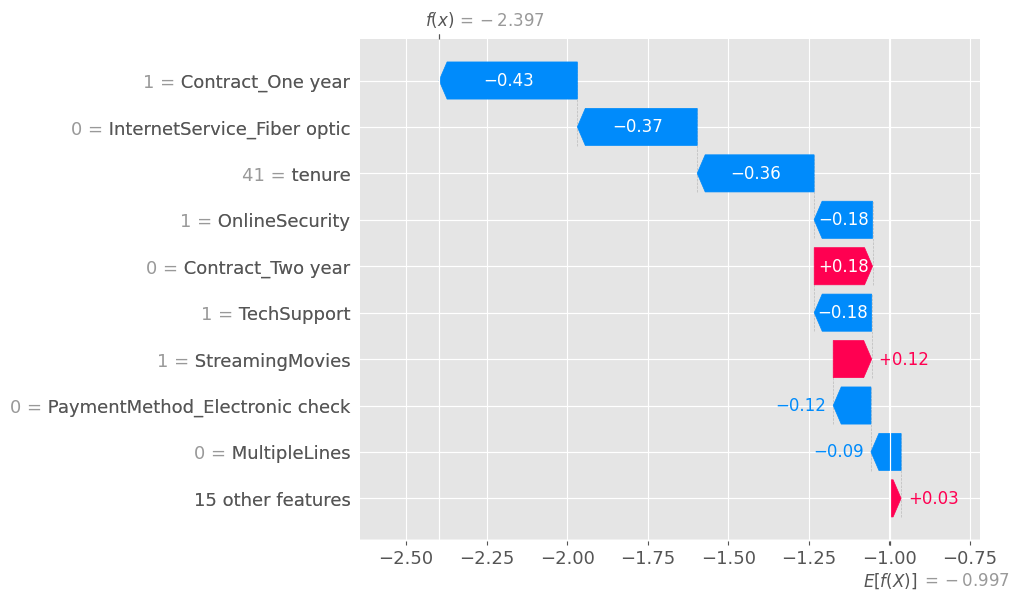

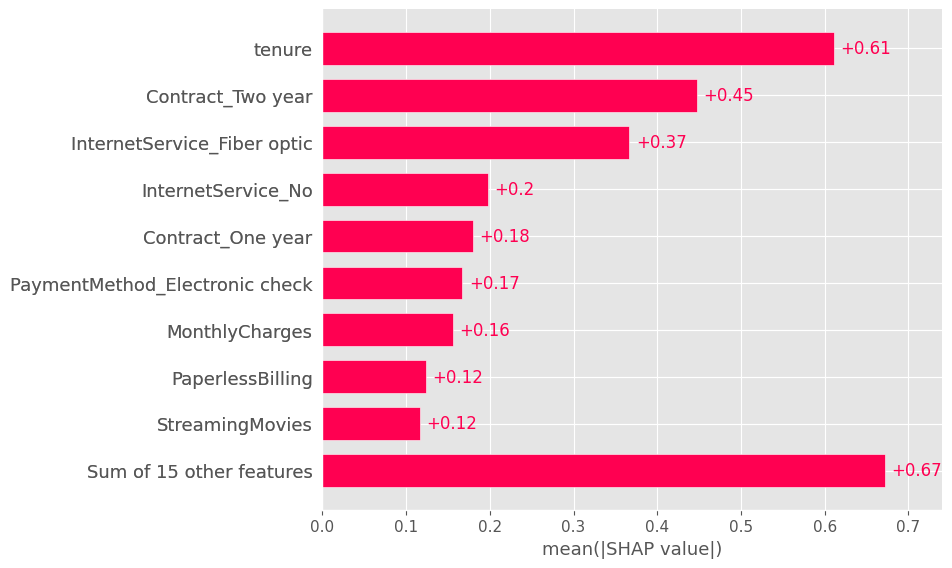

In [21]:
# explain predictions of model
explainer = shap.Explainer(best_xgb_model)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

# visualize the training set predictions
shap.plots.bar(shap_values)

The LLM did train a fresh model (i removed that part of the code), doesnt really matter though. Interesting to see that it did not go for the standard summary plot (I've added that in below). However the commentary it gave to the code was about the summary_plot method and the force_plot method. I guess things may become a bit mixed up if you arent specific enough.

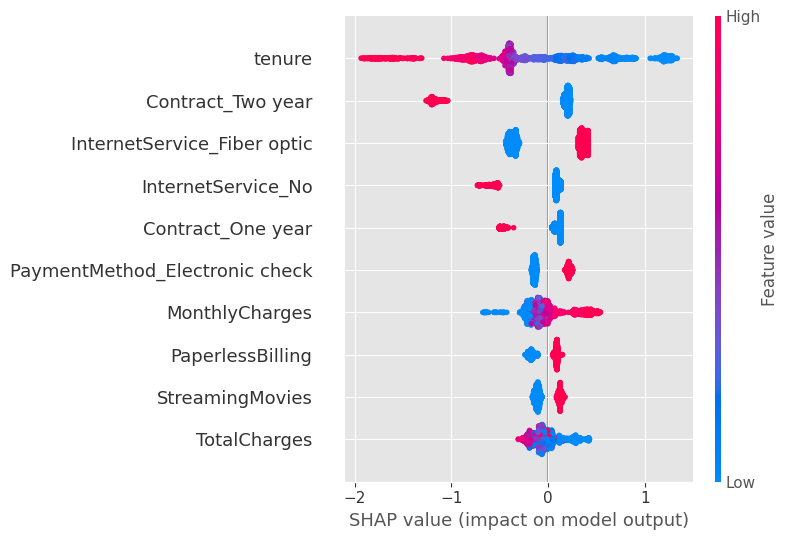

In [22]:
shap.summary_plot(shap_values,
                  X_test,
                  max_display=10)

Overall I'd say this went pretty well. The LLM's output generally worked right out of the box when compared to what it was giving us during the EDA. It didnt need to see our data so much here so things were more likely to just work.

Its shortcomings this time though were that it was using older ways of doing things (e.g. no f-strings, using depreciated methods). This is an issue with its training data. Its up to those training the model to curate the data set such that it reflects more up to date practices. Though some if one was editing legacy code that had to use older libary versions then they'd be out of luck!